# An introduction to Jiminy


Jiminy is a simulation framework built around the `pinocchio` rigidbody dynamics library, targeting the simulation of robotic systems. This document covers the use of jiminy in python for individual robotic simulation: usage in C++ is similar, see C++ API documentation and examples. For information about using jiminy in a learning context with Gym OpenAI, see examples in gym_jiminy. 

Jiminy supports the following features:

 - Simulating a single robot, represented by a URDF file, with possible ground interaction (modeled as a spring-damper mechanism). Note that interaction forces are only applied at user-specified frames, there is no mesh collision handling in jiminy for now.
 - Adding joint flexibility, modeled as a Serie-Elastic actuator.
 - Applying external forces on the system.
 - Applying kinematic constraints, such as fixed-body constraints.
 - Simulating multiple robots interacting, including closed kinematic trees.
 - Adding basic sensors on the system

## Basic example

To illustrate the first part of this tutorial, we will use as example the stabilization of a simple inverted pendulum.

Jiminy simulation rely on interfacing three fundamental objects : a Robot, a Controller, defining input for this robot, and an Engine, performing the integration. For convenience, connection between these objects is handled in python by the BasicSimulator class (this class does not exist in C++). Of course, it is always possible to instanciate these objects manually for more specific usage - see the unit tests for examples.

The robot is constructed from a URDF - this builds a jiminy.Model object - but extra information needs to be provided as well for a simulation: which sensors to use and what are their caracteristic ? Which joints have a motor attached and what are its properties ? What are the contact points with the ground (if any) ? All this are informations gathered to build a full robot.

So let's get our first example running: we set the inverted pendulum away from its upward position and watch it fall.

In [1]:
import numpy as np

import jiminy_py.core as jiminy # The main module of jiminy - this is what gives access to the Robot and Engine class.
from jiminy_py.simulator import BasicSimulator

mesh_root_path = "../data/"
urdf_path = mesh_root_path + "simple_pendulum/simple_pendulum.urdf"

# Create a jiminy.Robot from the urdf.
robot = jiminy.Robot()
robot.initialize(urdf_path)

# Attach a simple motor the pendulum base joint.
motor = jiminy.SimpleMotor("PendulumJoint")
robot.attach_motor(motor)
motor.initialize("PendulumJoint")

# Create the controller: for now, the motor is off and doesn't modify the output torque.
def controller(t, q, v, sensors_data, u):
    """,
    Controller callback method.
    Parameters:
        - t: current time (in s).
        - q: current system position (from the integrator).
             This is the real state of the system and does not come from any sensor.
        - v: current system velocity (from the integrator).
        - sensors_data : aggregated structure of all sensor data.
        - u: output torque.
    """
    u[:] = 0 # Notice the [:]: this is to assign 0 to the underlying object, to pass it by reference to C++.
             # Using instead u = np.zeros(1) would create a copy instead.

# Create a simulator using this robot and controller
simulator = BasicSimulator(robot)
simulator.set_controller(controller)

# Set initial condition and simulation length
x0 = np.array([0.1, 0])
simulation_duration = 10.0

# Launch the simulation
simulator.run(simulation_duration, x0)

The simulation generates a log of its comuptation: this log can be retrieved by using ```simulator.get_log``` - and written to a file for latter processing by the engine with ```simulator.engine.write_log```.

<IPython.core.display.Javascript object>


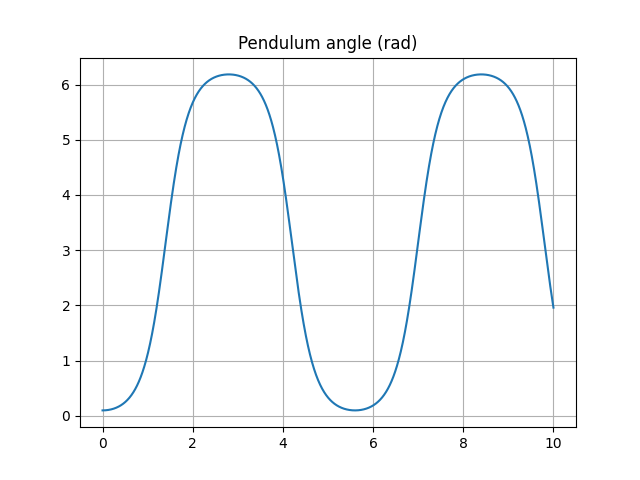

In [4]:
log_data, _ = simulator.get_log() # First output value is a dictionnary of logged variables, second a dictionnary
                                  # of parameters specified by the user to comment the log.
# Let's plot the joint position to see the pendulum fall.
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(log_data['Global.Time'], log_data['HighLevelController.currentPositionPendulum'])
plt.title('Pendulum angle (rad)')
plt.grid()
plt.show()

The results of a simulation can also be visualized in a 3D viewer: either `gepetto-gui` or `meshcat`. We use the latter here as it can be integrated in jupyter.

In [ ]:
from jiminy_py.viewer import play_logfiles

play_logfiles(robot, log_data, mesh_root_path=mesh_root_path, 
              camera_xyzrpy=([5., 0., 2e-5], [np.pi/2, 0.0, np.pi/2]))

Let's now add a controller: a simple PD to hold the pendulum straight.

In [35]:
Kp = 5000
Kd = 0.05

def controller(t, q, v, sensors_data, u):
    u[:] = - Kp * (q + Kd * v)
    
simulator.set_controller(controller)
simulator.run(simulation_duration, x0)
log_data, _ = simulator.get_log()
play_logfiles(robot, log_data, mesh_root_path=mesh_root_path)

## Adding external forces.

External forces can be applied to the system through a force profile : a function outputing a force on
a specific body as as a function of time dans state.

In [33]:
# Apply a force of 500N in the Y direction between t = 2.5 and t = 3s
def force_profile(t, q, v, f):
    if t > 2.5 and t < 3:
        f[1] = 200.0
    else:
        f[1] = 0.0

# Apply this force profile to a given frame.
simulator.engine.register_force_profile("PendulumMass", force_profile)
simulator.run(simulation_duration, x0)
log_data, _ = simulator.get_log()
play_logfiles(robot, log_data, mesh_root_path=mesh_root_path)